### Generative Adversarial Training using dl2
The architecture shown below is quite simple to implement. We train the discriminator and generator separately. We keep the generator fixed while we train the discriminator and vice versa. Discriminator training - we create a fake images using generator and label them 0, and label real images as 1. The discriminator gives a score in the range [0, 1]. Values close to 1 $\implies$ prediction = real and values close to 0 $\implies$ prediction = fake. We use cross entropy loss to train the discriminator. This means that the gradient of discriminator loss w.r.t prediction $D(I)$ (where $I$ is some input image $\in$ $R\cup G(\mathbf{\mathcal{N}})$ where $\mathbf{\mathcal{N}}$ is a set of gaussian priors and $R$ is the set of real images) is $D(I)-y$ where $y$ is the label (0 if fake, 1 if real). Training the discriminator is simple enough. Generator training - here we compose two neural networks together, i.e we measure the generator loss using the discriminator's prediction of the generated image. For the generator, we want $D(G(\mathcal{N}))$ equal to 1 (i.e, the discriminator thinks the fake image is real). Now the gradient of generator loss w.r.t to discriminator output is simply $1 - D(G(\mathcal{N}))$. But what is $\nabla_{\theta_G} D(G(\mathcal{N}))$? We use the chain rule! It simplifies to $D'(G(\mathcal{N}))\nabla_{\theta_G}G(\mathcal{N})$ where $D'(G(\mathcal{N}))$ is simply the gradient matrix in the input layer of the discriminator, which means we don't have compute gradient of loss w.r.t weights of the discriminator during training! We pass this gradient through the generator, compute parameter gradients of the generator and update the parameters. When we train the generator, we do gradient ascent instead of gradient descent (gradient ascent is simply gradient descent with a negative learning rate). 

In [1]:
import dl2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import Image
from tensorflow.keras.datasets import mnist

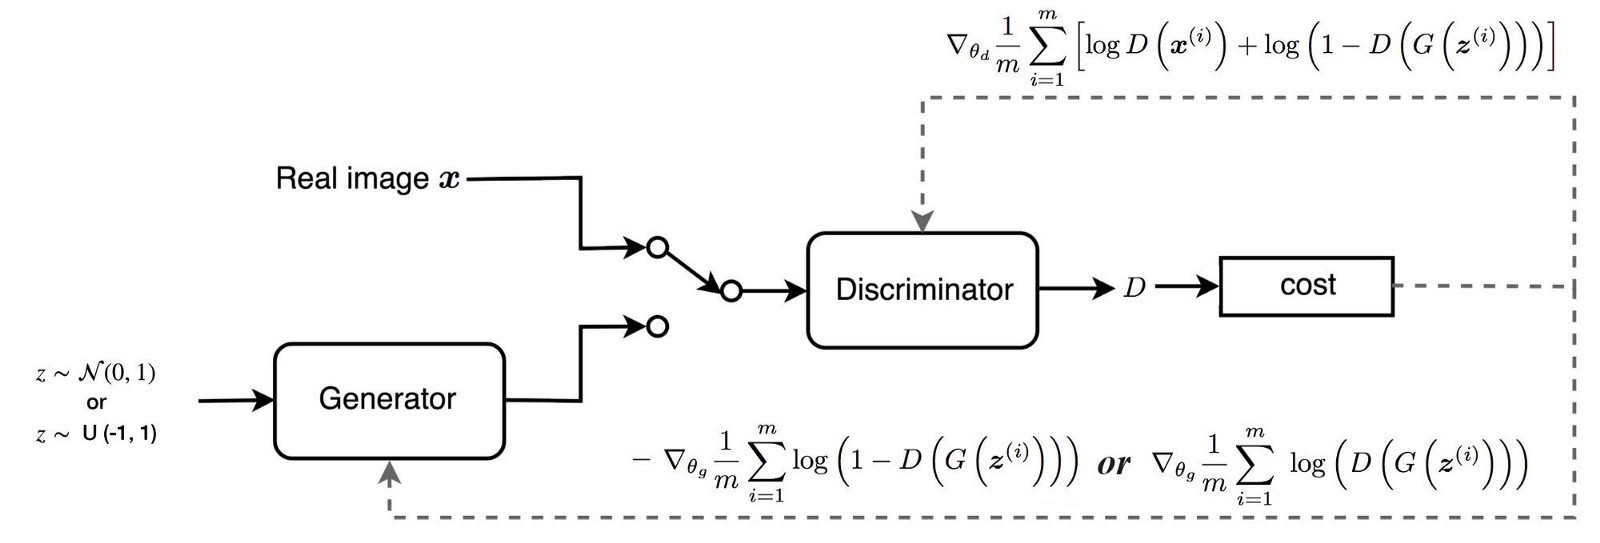

In [2]:
Image(filename='gan.jpeg')

Unfortunately, my library is not as fast as TensorFlow and achieving convergence in GANs is pretty challenging. I haven't implemented batch normalization or dropout in my library so I am using vanilla CNNs. We don't get realistic looking images. However, we can still do the training and make the discriminator classify noise as a real image..

### Initialize a small generator network

In [3]:
G = dl2.NN()
G.add(dl2.dense(200, input_dim=(100), activation='lrelu'))
G.add(dl2.expand(reshape=(10, 10, 2), activation='lrelu'))
G.add(dl2.conv2dT(channels=4, filters_dim=(5, 5), strides=(1, 1), activation='lrelu'))
G.add(dl2.conv2dT(channels=1, filters_dim=(2, 2), strides=(2, 2), activation='tanh'))
G.init()
G.info()

{'input_dim': 100, 'output_dim': 200, 'layer': 'dense', 'activation': 'lrelu', 'use_bias': True, 'requires_wgrad': True}
{'input_dim': 200, 'output_dim': (10, 10, 2), 'use_bias': True, 'layer': 'expand', 'activation': 'lrelu'}
{'input_dim': (10, 10, 2), 'output_dim': (14, 14, 4), 'use_bias': True, 'channels': 4, 'filters_dim': (5, 5), 'strides': (1, 1), 'layer': 'conv2dT', 'activation': 'lrelu', 'requires_wgrad': True}
{'input_dim': (14, 14, 4), 'output_dim': (28, 28, 1), 'use_bias': True, 'channels': 1, 'filters_dim': (2, 2), 'strides': (2, 2), 'layer': 'conv2dT', 'activation': 'tanh', 'requires_wgrad': True}
trainable parameters: 22184


### Initalize a small discriminator network

In [4]:
D = dl2.NN()
D.add(dl2.conv2d(filters=4, filters_dim=(3, 3), strides=(1, 1), input_dim=(28, 28, 1), activation='lrelu'))
D.add(dl2.conv2d(filters=4, filters_dim=(3, 3), strides=(2, 2), activation='lrelu'))
D.add(dl2.pool(pool_size=(3, 3), strides=(3, 3)))
D.add(dl2.flatten())
D.add(dl2.dense(200, activation='lrelu'))
D.add(dl2.dense(1, activation='sigmoid'))
D.init()
D.info()

{'input_dim': (28, 28, 1), 'output_dim': (26, 26, 4), 'use_bias': True, 'filters': 4, 'filters_dim': (3, 3), 'strides': (1, 1), 'layer': 'conv2d', 'activation': 'lrelu', 'requires_wgrad': True}
{'input_dim': (26, 26, 4), 'output_dim': (12, 12, 4), 'use_bias': True, 'filters': 4, 'filters_dim': (3, 3), 'strides': (2, 2), 'layer': 'conv2d', 'activation': 'lrelu', 'requires_wgrad': True}
{'input_dim': (12, 12, 4), 'output_dim': (4, 4, 4), 'pool_size': (3, 3), 'strides': (3, 3), 'layer': 'pool', 'activation': 'none'}
{'input_dim': (4, 4, 4), 'output_dim': 64, 'use_bias': True, 'layer': 'flatten', 'activation': 'none'}
{'input_dim': 64, 'output_dim': 200, 'layer': 'dense', 'activation': 'lrelu', 'use_bias': True, 'requires_wgrad': True}
{'input_dim': 200, 'output_dim': 1, 'layer': 'dense', 'activation': 'sigmoid', 'use_bias': True, 'requires_wgrad': True}
trainable parameters: 16725


### Using MNIST digits for adversarial training

In [5]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = np.expand_dims(x_train, 3) / 255.0, np.expand_dims(x_test, 3) / 255.0
noise = np.random.normal(0, 1, 100)

In [6]:
real_image, fake_image = x_train[0], G.forward(noise)

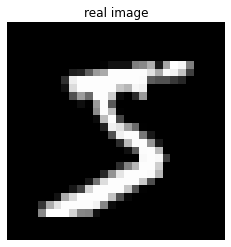

In [7]:
plt.axis('off')
plt.title('real image')
plt.imshow(real_image[:, :, 0], cmap='gray')

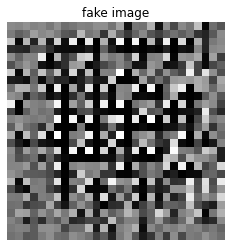

In [8]:
plt.axis('off')
plt.title('fake image')
plt.imshow(fake_image[:, :, 0], cmap='gray')

In [9]:
D.forward(real_image)

array([0.11004149])

In [10]:
D.forward(fake_image)

array([0.07444745])

The discriminator currently gives both the real AND fake image pretty much the same score. But we want a score close to 1 for the real image and a score close to 0 for the fake image. Let's train the discriminator!

### Training discriminator

In [11]:
D.opt, D.loss_fn = dl2.SGD(D.params(), 1e-2), 'ce'
D.tqdm_disable = True
history = D.fit([real_image, fake_image], [np.array([1]), np.array([0])], epochs=100)

In [12]:
D.forward(real_image)

array([0.99337415])

In [13]:
D.forward(fake_image)

array([0.01192013])

As we see above, the discriminator has been trained! It now gives a score close to 1 for the real image and a score close to 0 for the fake image.

### Training generator

In [14]:
def set_requires_wgrads(model, requires_wgrads):
    for i in range(model.n):
        if model.layers[i]['layer'] == 'conv2d' or model.layers[i]['layer'] == 'dense' or model.layers[i]['layer'] == 'conv2dT':
            model.layers[i]['requires_wgrads'] = requires_wgrads

In [15]:
# before training
D.forward(fake_image)

array([0.01192013])

In [16]:
G.opt, G.loss_fn = dl2.Adam(G.params(), -5e-2), 'direct' 
set_requires_wgrads(D, False)  
G.tqdm_disable = True
history = G.fit([noise], [D.backward(1 - D.forward(fake_image))[-1]], epochs=1000)
fake_image = G.forward(noise)

In [17]:
# after training
D.forward(fake_image)

array([0.99652814])

After training the generator, the discriminator is now fooled :')...Let's see what image the generator came up with to fool the discriminator.

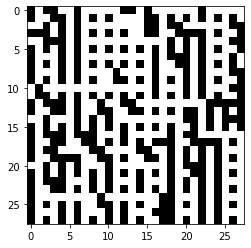

In [18]:
plt.imshow(fake_image[:, :, 0], cmap='gray')

The discriminator was trained on just a single training example. So it's quite easy to fool the discriminator. In this case, the generator came up with an image that looks like noise and is enough to fool the discriminator. 

In [19]:
D.forward(real_image)

array([0.99337415])

And the discriminator thinks still thinks the real image is real because we don't update the parameters of the discriminator when we are training the generator.